# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from skimage.draw import rectangle

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

DATA_DIR = os.path.join(ROOT_DIR, "../data")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
# Disable gpus
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# Enable all gpus
!export HIP_VISIBLE_DEVICES=0,1,2,3

In [ ]:
## Quick fixes until I can update the image

#Can probably just remove tensorflow from the requirements since it is installed automatically in the docker container ...
# !pip uninstall -y tensorflow
# !pip install tensorflow-gpu

#Fix the multiple gpu usage bug, after applying fix from https://github.com/matterport/Mask_RCNN/pull/1261/files
# %cd {ROOT_DIR}
# !python3 setup.py install


## Pull in annotations from database (from Simplot)

In [5]:
import pyodbc
import os
import pandas as pd

DATA_DIR = os.path.join(ROOT_DIR, "../data")

COCO_MODEL_PATH = os.path.join(DATA_DIR, "mask_rcnn_coco.h5")

ANNOTATION_COLS = ['XMax','XMin','YMin','YMax','LabelDescription']

passwd = os.environ['dgs_sandbox_pwd']

conn = pyodbc.connect('DSN=BIdevDatabase;'
                      'Database=Sandbox;'
                      'UID=DGSuser;'
                      'PWD=' + passwd)


class_descriptions = pd.read_sql("SELECT LabelName, LabelDescription from [kaggle].[Class_Description]",conn)

class_descriptions['LabelID'] = class_descriptions.index

display(class_descriptions.head())

#This now holds the annotation information.
bboxes = pd.read_sql("SELECT ImageID, XMax, XMin, YMin, YMax, LabelName FROM [Sandbox].[kaggle].[Combined_Set_Detection_BBox]", conn)

annotations = pd.merge(bboxes,class_descriptions, on='LabelName',how='inner')

display(annotations.head())

# This now holds the list of images
image_paths = pd.read_sql("SELECT ImageID, RelativePath, Height, Width, Mode from [kaggle].[Image_Path]", conn)

display(image_paths.head())

# Inner join on the two dataframes, so we now have images combined with associated annotations
annotated_image_paths = pd.merge(image_paths,annotations, on='ImageID',how='inner')

display(annotated_image_paths.head())

,LabelName,LabelDescription,LabelID
0,/m/061hd_,Infant bed,0
1,/m/06m11,Rose,1
2,/m/03120,Flag,2
3,/m/01kb5b,Flashlight,3
4,/m/0120dh,Sea turtle,4


,ImageID,XMax,XMin,YMin,YMax,LabelName,LabelDescription,LabelID
0,5a27bbe9ab1ede93,0.706875,0.026250,0.553571,0.999060,/m/04p0qw,Billiard table,46
1,2fe71cd9dc2acfdd,0.999333,0.000000,0.000000,0.998565,/m/04p0qw,Billiard table,46
2,ea2422b5f4c97b42,0.868228,0.000000,0.168945,0.431641,/m/04p0qw,Billiard table,46
3,ea2422b5f4c97b42,0.888726,0.000000,0.567383,0.999023,/m/04p0qw,Billiard table,46
4,2fef02bb3916fec3,0.481250,0.045833,0.402778,0.687963,/m/04p0qw,Billiard table,46


,ImageID,RelativePath,Height,Width,Mode
0,95259d687d440013,train/95259d687d440013.jpg,1024,1024,RGB
1,ccce42a1f4ed2c96,train/ccce42a1f4ed2c96.jpg,1024,768,RGB
2,30723bdea123ccdf,validation/30723bdea123ccdf.jpg,683,1024,RGB
3,cba0bd46fcddd85d,train/cba0bd46fcddd85d.jpg,1024,1024,RGB
4,cc88539b5c74a0c0,train/cc88539b5c74a0c0.jpg,1024,1024,RGB


,ImageID,RelativePath,Height,Width,Mode,XMax,XMin,YMin,YMax,LabelName,LabelDescription,LabelID
0,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.697656,0.089844,0.000000,0.936458,/m/04yx4,Man,113
1,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.388281,0.221875,0.000000,0.309375,/m/0dzct,Human face,279
2,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.960156,0.778906,0.000000,0.300000,/m/0dzct,Human face,279
3,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.332812,0.000000,0.864583,0.998958,/m/050gv4,Plate,472
4,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.946875,0.605469,0.836458,0.998958,/m/050gv4,Plate,472


## Pull in annotations from home

In [4]:
import pandas as pd

ANN_CACHE = '/home/thomas/Data/cache/'

class_descriptions = pd.read_parquet(ANN_CACHE + 'class_desc.parquet.gzip')

class_descriptions['LabelID'] = class_descriptions.index

display(class_descriptions.head())

#This now holds the annotation information.
bboxes = pd.read_parquet(ANN_CACHE + 'bboxes.parquet.gzip')

annotations = pd.merge(bboxes,class_descriptions, on='LabelName',how='inner')

display(annotations.head())

image_paths = pd.read_parquet(ANN_CACHE + 'image_paths.parquet.gzip')

display(image_paths.head())

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
pyarrow or fastparquet is required for parquet support

##  Detect only certain classes ... for now

In [6]:
#Only look at the apple class for now ... RESET INDEX IS IMPORTANT 
# since this classes uses array indexing a lot
classes_of_interest = class_descriptions.iloc[475:476].reset_index()

## Configurations

In [24]:
class KaggleConfig(Config):
    
    NAME = "kaggle"

    #TODO experiment with this
    GPU_COUNT = 4
    IMAGES_PER_GPU = 2  # TODO how many can we use, authors had 2 for 12 GB, we have 32 GB so ...

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(classes_of_interest) #1 + len(class_descriptions)  # + 1 for background

    #TODO experiment with this
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.75
    
config = KaggleConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      4
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

## Utility Functions

In [8]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def images_with_classes(image_paths, classes):
    image_ids_with_desired_classes = bboxes[bboxes['LabelName'].isin(classes['LabelName'])]['ImageID'].unique()
    return image_paths[image_paths['ImageID'].isin(image_ids_with_desired_classes)]

## Subclass Utils.Dataset

In [9]:
class KaggleImageDataset(utils.Dataset):

    #TODO better method documentation needed for this
    
    def load_kaggle_images(self, dataset_dir, image_paths, classes=class_descriptions):
        """Load a subset of the image dataset.
        dataset_dir: The root directory of the image dataset.
        classes: Dataframe : If provided, only loads images that have the given classes.
        """

        #Assumes class_descriptions, annotations, and bboxes are global DataFrames
        
        images = images_with_classes(image_paths,classes)
        
        #add this as a hack to allow a subset of classes
        #TODO can clean some stuff up if we are going to use all of the classes
        tmp_indices = {}

        # Add classes
        for i,row in classes.iterrows():
            tmp_indices[row['LabelID']] = i
            self.add_class("openImages", i, row['LabelDescription'])
        
        # Select down to the annotations instances for the desired classes
        salient_anns = annotations[annotations['LabelID'].isin(classes['LabelID'].values)]
        
        # Add images
        for i,row in images.iterrows():
            
            anns = salient_anns[salient_anns['ImageID'] == row['ImageID']].copy()

            #look up the new class id (which is used as an index, arghhh), add 1 since background is assigned 0
            anns['classID'] = anns.apply (lambda row: tmp_indices[row['LabelID']] + 1, axis=1)
            
            self.add_image(
                "openImages", image_id=i,
                path=os.path.join(dataset_dir, row['RelativePath']),
                width=row["Width"],
                height=row["Height"],
                annotations=anns)
            

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        # Create rectangular bounding box since we are doing object detection, not segmentation
        # desired dimension is [height, width, instance_count]
        img = self.image_info[image_id]
        
        mask = np.zeros([img["height"], img["width"], len(img["annotations"])],
                        dtype=np.uint8)
        
        for i,(_,p) in enumerate(img["annotations"].iterrows()):
            # Create rectangular bounding box since we are doing object detection, not segmentation
    
            xmax = int(img["width"]*p['XMax'])
            xmin = int(img["width"]*p['XMin'])
            ymin = int(img["height"]*p['YMin'])
            ymax = int(img["height"]*p['YMax'])
            
            start = (ymin, xmin)  #top left corner ... are coordinates reversed?
            end = (ymax, xmax)  #height and width
            rr, cc = rectangle(start, end=end, shape=(img["height"],img["width"]))
            
            mask[rr, cc, i] = 1

        
        # Return mask, and array of class IDs of each instance.
        return mask.astype(np.bool), np.array(img['annotations']['classID'].values, dtype=np.int32)

    def image_reference(self, image_id):
        return self.image_info[image_id]['path']
    

## Load dataset and display samples

In [10]:
val_paths = image_paths[image_paths['RelativePath'].str.contains('validation',regex=False)]
train_paths = image_paths[image_paths['RelativePath'].str.contains('train',regex=False)]

# Training dataset
dataset_train = KaggleImageDataset()
dataset_train.load_kaggle_images(DATA_DIR, train_paths, classes_of_interest)
dataset_train.prepare()

# Validation dataset
dataset_val = KaggleImageDataset()
dataset_val.load_kaggle_images(DATA_DIR, val_paths, classes_of_interest)
dataset_val.prepare()

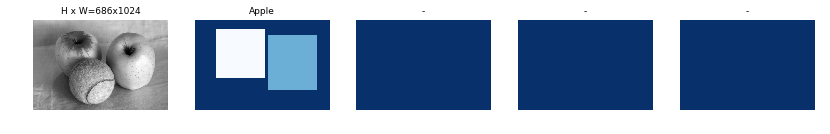

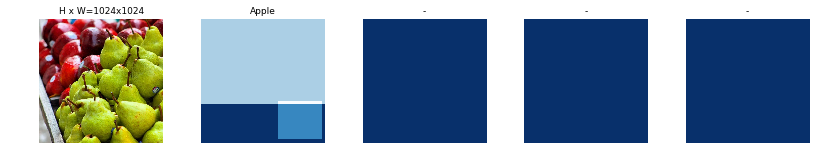

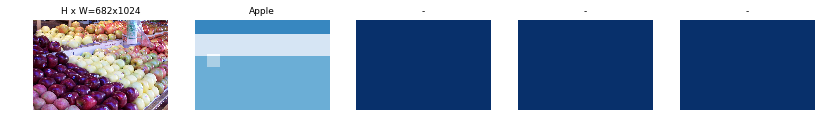

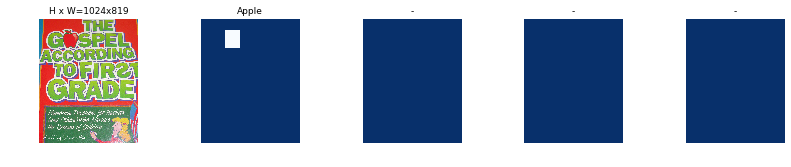

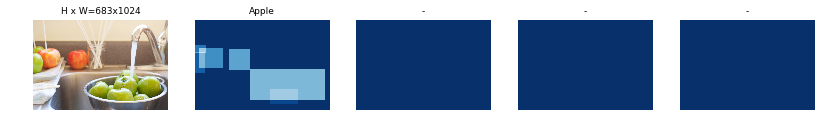

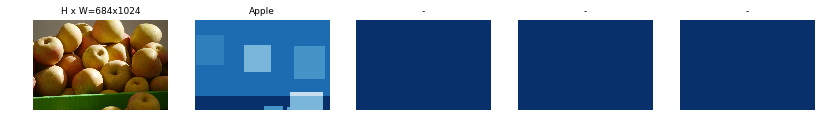

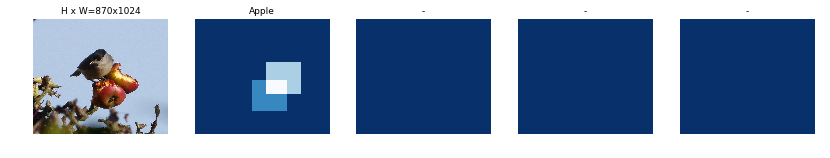

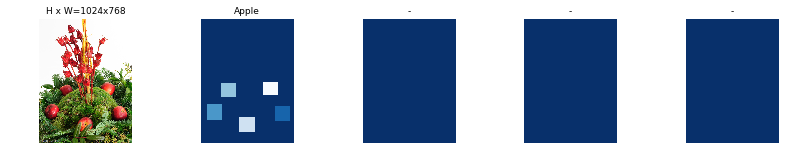

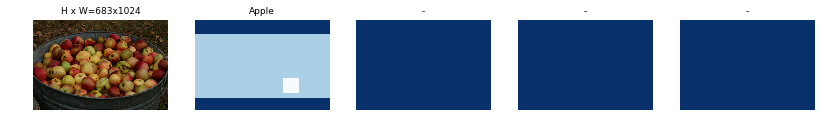

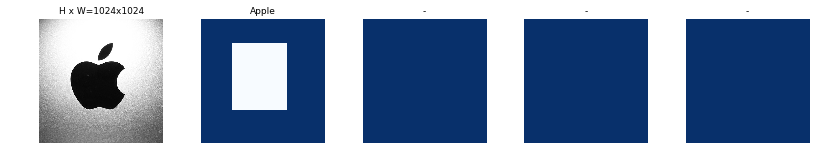

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [25]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [26]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/nbuser/repo/logs/kaggle20190805T2244/mask_rcnn_kaggle_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))